## Requirements
Python 3.6.3  
numpy==1.13.3  
pandas==0.20.3  
tqdm==4.25.0  
lightgbm==2.1.2  
scikit-learn==0.19.1  
matplotlib==2.1.0  
seaborn==0.8

## Run

* Add data into "../input" folder.
* Run this notebook.   
  around 30 minites in laptop. (if SHORT_RUN == True, 10 minites)

In [1]:
import numpy as np
import pandas as pd
import os
import itertools
from tqdm import tqdm_notebook
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, LabelEncoder
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 

SHORT_RUN = False

## Load Files

In [2]:
sales = pd.read_csv("../input/sales_train_v2.csv")
item_categories = pd.read_csv("../input/item_categories.csv")
items = pd.read_csv("../input/items.csv")
submission = pd.read_csv("../input/sample_submission.csv")
shops = pd.read_csv("../input/shops.csv")
test = pd.read_csv("../input/test.csv")
index_cols = ['shop_id', 'item_id', 'date_block_num']

## Preprocess / Feature Engineering

### lag feature 

* includes statistical features(target_shop sum, target_item sum)

In [3]:
def create_all_data():

    # enumerate (shop-month, item_id, date_block_num) combinations
    grid = []
    for block_num in sales['date_block_num'].unique():
        cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
        cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
        grid.append(np.array(list(itertools.product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
    
    # (shop-month, item_id) aggregates
    gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

    # shop-month aggregates
    gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # item-month aggregates
    gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)
    
    return all_data

all_data = create_all_data()

C:\Users\dai\Anaconda3\lib\site-packages\pandas\core\groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


### text feature

* extract text feature from shop names

In [4]:
shops["shop_name1"] = shops["shop_name"].str.split(" ").map(lambda tpl:tpl[0])
shops["shop_name2"] = shops["shop_name"].str.split(" ").map(lambda tpl:tpl[1])
shops["shop_name1"] = LabelEncoder().fit_transform(shops["shop_name1"])
shops["shop_name2"] = LabelEncoder().fit_transform(shops["shop_name2"])

## EDA
* target distribution
* time trend

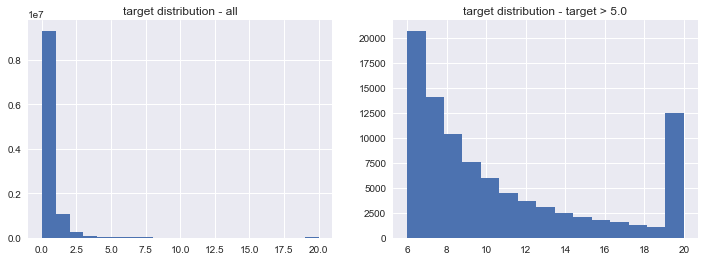

In [5]:
# target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
d1 = all_data["target"]
d2 = d1[d1 > 5.0]
axes[0].hist(np.clip(d1, 0.0, 20.0), bins=20)
axes[1].hist(np.clip(d2, 0.0, 20.0), bins=15)
axes[0].set_title("target distribution - all")
axes[1].set_title("target distribution - target > 5.0")
plt.show()

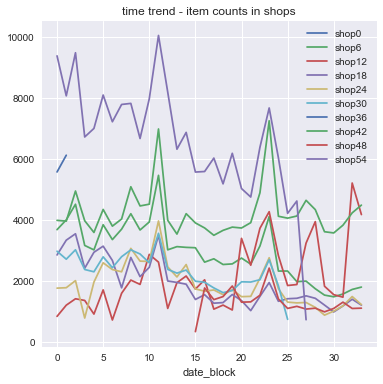

In [6]:
# time trend
g_shop = all_data.groupby(["shop_id", "date_block_num"])["target"].sum().reset_index()
piv = pd.pivot_table(g_shop, values="target", index="shop_id", columns="date_block_num")

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in piv.index:
    if i % 6 == 0:
        ax.plot(piv.columns, piv.loc[i].values, label = "shop{}".format(i))

ax.set_title("time trend - item counts in shops")
ax.set_xlabel("date_block")
ax.legend()
plt.show()

## Aggregate Features

In [7]:
# set train/test indices
train = all_data[index_cols].copy()
test['date_block_num'] = 34
test = test[index_cols].copy()
target = all_data["target"]

In [8]:
def add_shift_features(df):    
    df = df.copy()        
    shift_range = [1, 2, 3, 4, 5, 12]
    for month_shift in tqdm_notebook(shift_range):
        cols_to_rename = list(all_data.columns.difference(index_cols)) 
        train_shift = all_data[index_cols + cols_to_rename].copy()
        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)
        df = pd.merge(df, train_shift, on=index_cols, how='left').fillna(0)
    return df

def add_item_category(df):
    df = df.copy()
    item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
    df = pd.merge(df, item_category_mapping, how='left', on='item_id')
    return df

def add_shop_text_features(df):
    df = df.copy()
    df = pd.merge(df, shops[["shop_id", "shop_name1", "shop_name2"]], how='left', on='shop_id')
    return df

In [9]:
# add features - train
train2 = train.copy()
train2 = add_shift_features(train2)
train2 = add_item_category(train2)
train2 = add_shop_text_features(train2)

# don't use old data from year 2013
train2 = train2[train['date_block_num'] >= 12] 
target2 = target[train['date_block_num'] >= 12]

# add features - test
test2 = test.copy()
test2 = add_shift_features(test2)
test2 = add_item_category(test2)
test2 = add_shop_text_features(test2)

train2 = train2.reset_index(drop=True)
test2 = test2.reset_index(drop=True)
target2 = target2.reset_index(drop=True)

A Jupyter Widget

A Jupyter Widget

# modeling

* timewise split
* optimized for rmse, clipped into (0.0, 20.0)

### Mean Encoding

* KFold method(time-based)

In [10]:
_train = train2
_target = target2
_test = test2

category_id_enc_tr = np.zeros((len(_train), 1))
category_id_enc_te = np.zeros((len(_test), 1))

if SHORT_RUN:
    train_block_start = 29
    validate_date_block_start = 30
    test_date_block = 34
else:
    train_block_start = 12
    validate_date_block_start = 13
    test_date_block = 34    

def mean_encoding(x_tr, y_tr, x_va):
    data = x_tr[["item_category_id"]].copy()
    data["target"] = y_tr
    item_id_target_mean = data.groupby('item_category_id')["target"].mean()
    ret = x_va["item_category_id"].map(item_id_target_mean)    
    ret = ret.fillna(y_tr.mean())
    return ret
    
for vb in range(validate_date_block_start, test_date_block):
    block_tr = _train["date_block_num"]
    idx_tr = _train[(block_tr >= train_block_start) & (block_tr < vb)].index
    idx_va = _train[block_tr == vb].index
    x_tr = _train.iloc[idx_tr]
    x_va = _train.iloc[idx_va]
    y_tr = _target.iloc[idx_tr]
    me_va = mean_encoding(x_tr, y_tr, x_va)
    category_id_enc_tr[idx_va, 0] = me_va

for vb in [test_date_block]:
    block_tr = _train["date_block_num"]
    idx_tr = _train[(block_tr >= train_block_start)].index
    x_tr = _train.iloc[idx_tr]
    x_va = _test
    y_tr = _target.iloc[idx_tr]
    me_va = mean_encoding(x_tr, y_tr, x_va)
    category_id_enc_te = me_va

### Models

* changed hyperparameters
* preprocessing is used for linear model

In [11]:
# training
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

lr_params = { "alpha" : 0.5}

class ModelLGB:
        
    def train(self, x_tr, y_tr, x_va, y_va):
        self.model = lgb.train(lgb_params, lgb.Dataset(x_tr, label=y_tr), 100)
        return self.model

    def predict(self, x_te):
        return self.model.predict(x_te)
    
class ModelLR:

    def train(self, x_tr, y_tr, x_va, y_va):
        self.scaler = StandardScaler()
        self.scaler.fit(x_tr.values)
        self.model = Ridge(alpha=lr_params["alpha"])
        scaled = self.scaler.transform(x_tr.values)
        self.model.fit(scaled, y_tr)
        return self.model

    def predict(self, x_te):
        scaled = self.scaler.transform(x_te.values)
        return self.model.predict(scaled)
    

### 1st level
* lightgbm model
* linear model

In [12]:
train3 = train2.copy()
train3["category_id_enc"] = category_id_enc_tr
test3 = test2.copy()
test3["category_id_enc"] = category_id_enc_te

# clip y range in (0.0, 20.0), as competition evaluation does.
target3 = np.clip(target2, 0.0, 20.0).copy()

_train = train3
_target = target3
_test = test3

In [13]:
# use only blocks where mean encoded feature is calculated

if SHORT_RUN:
    train_block_start = 30
    validate_date_block_start = 31
    test_date_block = 34
else:
    train_block_start = 13
    validate_date_block_start = 14
    test_date_block = 34

meta_tr = np.zeros((len(_train), 2))
meta_te = np.zeros((len(_test), 2))
scores = []

for vb in range(validate_date_block_start, test_date_block):
    block_tr = _train["date_block_num"]
    idx_tr = _train[(block_tr >= train_block_start) & (block_tr < vb)].index
    idx_va = _train[block_tr == vb].index
    to_drop_cols = ['date_block_num', 'shop_id', 'item_id']
    x_tr = _train.iloc[idx_tr].drop(to_drop_cols, axis=1)
    x_va = _train.iloc[idx_va].drop(to_drop_cols, axis=1)
    y_tr = _target.iloc[idx_tr]
    y_va = _target.iloc[idx_va]
    
    model1 = ModelLGB()
    model2 = ModelLR()
    model1.train(x_tr, y_tr, x_va, y_va)
    model2.train(x_tr, y_tr, x_va, y_va)
    pred_va1 = model1.predict(x_va)
    pred_va2 = model2.predict(x_va)
    meta_tr[idx_va, 0] = pred_va1
    meta_tr[idx_va, 1] = pred_va2

    score1 = mean_squared_error(y_va, pred_va1)
    score2 = mean_squared_error(y_va, pred_va2)
    scores.append((score1, score2))
    print("validation score block {}: {}, {}".format(vb, score1, score2))

scores = np.array(scores)
print("validation score mean: {}".format(scores.mean(axis=0)))

for vb in [test_date_block]:
    to_drop_cols = ['date_block_num', 'shop_id', 'item_id']
    block_tr = _train["date_block_num"]
    idx_tr = _train[(block_tr >= train_block_start)].index
    x_tr = _train.iloc[idx_tr].drop(to_drop_cols, axis=1)
    x_va = _test.drop(to_drop_cols, axis=1)
    y_tr = _target.iloc[idx_tr]
    model1 = ModelLGB()
    model2 = ModelLR()
    model1.train(x_tr, y_tr, None, None)
    model2.train(x_tr, y_tr, None, None)
    pred_va1 = model1.predict(x_va)
    pred_va2 = model2.predict(x_va)
    meta_te[:, 0] = pred_va1
    meta_te[:, 1] = pred_va2


validation score block 14: 0.928716171255225, 1.3043674232249216
validation score block 15: 0.7536808680303272, 0.9908468368658495
validation score block 16: 0.7346945718796681, 1.0700847501794104
validation score block 17: 0.6056288028955092, 0.9001462991420954
validation score block 18: 0.5789109105688458, 0.8109744481979527
validation score block 19: 0.7726907991708617, 1.0773522862466904
validation score block 20: 0.8178446897187716, 1.2199490143237546
validation score block 21: 1.0168191550370784, 1.4209287607113286
validation score block 22: 1.0155485551952648, 1.5092236884787498
validation score block 23: 1.5135058903575405, 2.080915503665809
validation score block 24: 0.7315301217328093, 1.3144494310035932
validation score block 25: 0.6482843163060625, 1.2365233053232982
validation score block 26: 0.6000743040045928, 1.090040659210965
validation score block 27: 0.7977466084865346, 1.014426143757152
validation score block 28: 0.6770224791150194, 1.2072109038818333
validation sco

### 2nd level 
* linear model

In [14]:
train4 = train3[["date_block_num"]].copy()
train4["meta_1"] = meta_tr[:, 0]
train4["meta_2"] = meta_tr[:, 1]

test4 = test3[["date_block_num"]].copy()
test4["meta_1"] = meta_te[:, 0]
test4["meta_2"] = meta_te[:, 1]

_train = train4
_target = target3
_test = test4

In [15]:
# use only blocks where meta feature is calculated

if SHORT_RUN:
    train_block_start = 31
    validate_date_block_start = 32
    test_date_block = 34
else:
    train_block_start = 14
    validate_date_block_start = 15
    test_date_block = 34

meta2_tr = np.zeros((len(_train), 1))
meta2_te = np.zeros((len(_test), 1))
scores_2nd = []

for vb in range(validate_date_block_start, test_date_block):
    block_tr = _train["date_block_num"]
    idx_tr = _train[(block_tr >= train_block_start) & (block_tr < vb)].index
    idx_va = _train[block_tr == vb].index
    to_drop_cols = ['date_block_num']
    x_tr = _train.iloc[idx_tr].drop(to_drop_cols, axis=1)
    x_va = _train.iloc[idx_va].drop(to_drop_cols, axis=1)
    y_tr = _target.iloc[idx_tr]
    y_va = _target.iloc[idx_va]
    
    model1 = ModelLR()
    model1.train(x_tr, y_tr, x_va, y_va)
    pred_va1 = model1.predict(x_va)
    meta2_tr[idx_va, 0] = pred_va1

    score1 = mean_squared_error(y_va, pred_va1)
    scores_2nd.append((score1, ))
    print("validation score block {}: {}".format(vb, score1))

scores_2nd = np.array(scores_2nd)
print("validation score mean: {}".format(scores_2nd.mean(axis=0)))

for vb in [test_date_block]:
    to_drop_cols = ['date_block_num']
    idx_tr = _train[(block_tr >= train_block_start)].index
    x_tr = _train.iloc[idx_tr].drop(to_drop_cols, axis=1)
    x_va = _test.drop(to_drop_cols, axis=1)
    y_tr = _target.iloc[idx_tr]
    model1 = ModelLR()
    model1.train(x_tr, y_tr, None, None)
    pred_va1 = model1.predict(x_va)
    meta2_te[:, 0] = pred_va1

validation score block 15: 0.7371524049147798
validation score block 16: 0.7529681710774813
validation score block 17: 0.6316268563770899
validation score block 18: 0.5793811103028392
validation score block 19: 0.779022977902452
validation score block 20: 0.8218557467105134
validation score block 21: 1.017535793394832
validation score block 22: 1.0156772782640084
validation score block 23: 1.5125062123528288
validation score block 24: 0.7571237428589614
validation score block 25: 0.6518047034434274
validation score block 26: 0.5996484116541445
validation score block 27: 0.7960043580343723
validation score block 28: 0.680343808498972
validation score block 29: 0.6042036402567258
validation score block 30: 0.5188164897333235
validation score block 31: 0.6207758005969615
validation score block 32: 0.7703513361332813
validation score block 33: 0.8250709779540422
validation score mean: [ 0.77220367]


## Submission

In [16]:
# create submission
os.makedirs("../submission", exist_ok=True)
submission["item_cnt_month"] = meta2_te
submission.to_csv("../submission/subm.csv", index=False)

(public and private LB scores are: 0.928847 and 0.939055)